In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi,random

## Implementation of Teleportation protocol
Implement quantum gates  using teleportation
Use the barrier function creates a visual separation
Test that the protocol works correctly for different state vectors.
Proof that Q was successfully teleported into B

In [ ]:
qubit = QuantumRegister(1, 'Q')
ebit0 = QuantumRegister(1, 'A')
ebit1 = QuantumRegister(1, 'B')
a = ClassicalRegister(1, 'a')
b = ClassicalRegister(1, 'b')

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)


#prepare ebit for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()



#Alice operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'Q'), 0), Qubit(QuantumRegister(1, 'A'), 0), Qubit(QuantumRegister(1, 'B'), 0)), clbits=())

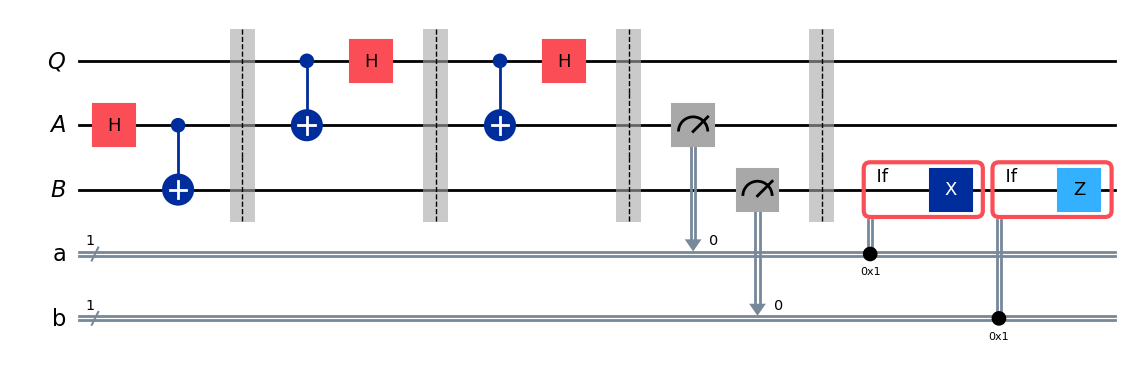

In [ ]:

#Alice measurements and sends classicial bits to Bob
protocol.measure(ebit0, a)
protocol.measure(ebit1, b)
protocol.barrier()

#bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

display(protocol.draw('mpl'))

The barrier function creates a visual
separation making the circuit diagram more readable, and it also prevents Qiskit from
performing various simplifications and optimizations across barriers during compilation
when circuits are run on real hardware. The if_test function applies an operation
conditionally depending on a classical bit or register.
The circuit first initializes (A,B) to be in a ∣φ+⟩ state (which is not part of the protocol
itself), followed by Alice's operations, then her measurements, and finally Bob's
operations.
To test that the protocol works correctly, we'll apply a randomly generated single-qubit
gate to the initialized ∣0⟩ state of Q to obtain a random quantum state vector to be
teleported. By applying the inverse (i.e., conjugate transpose) of that gate to BB after the
protocol is run, we can verify that the state was teleported by measuring to see that it
has returned to the ∣0⟩ state.
First we'll randomly choose a unitary qubit gate.

In [10]:
random_gate = UGate(theta=random.uniform(0, 2*pi), phi=random.uniform(0, 2*pi), lam=random.uniform(0, 2*pi)) 

display(random_gate.to_matrix)

<bound method Gate.to_matrix of Instruction(name='u', num_qubits=1, num_clbits=0, params=[3.3633483771007366, 3.462705752533492, 2.8795353028988315])>

Now we'll create a new testing circuit that first applies our random gate to Q then runs
the teleportation circuit, and finally applies the inverse of our random gate to the qubit B
and measures. The outcome should be 0 with certainty.

In [16]:
#create a new circuit to test the protocol using the same bits and qubits
test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

#start with a randomly selected gate on Q
test.append(random_gate, qubit)
test.barrier()

#compose with the teleportation protocol
test = test.compose(protocol)
test.barrier()  

#apply the inverse of the random gate to ebit1

test.append(random_gate.inverse(), ebit1)

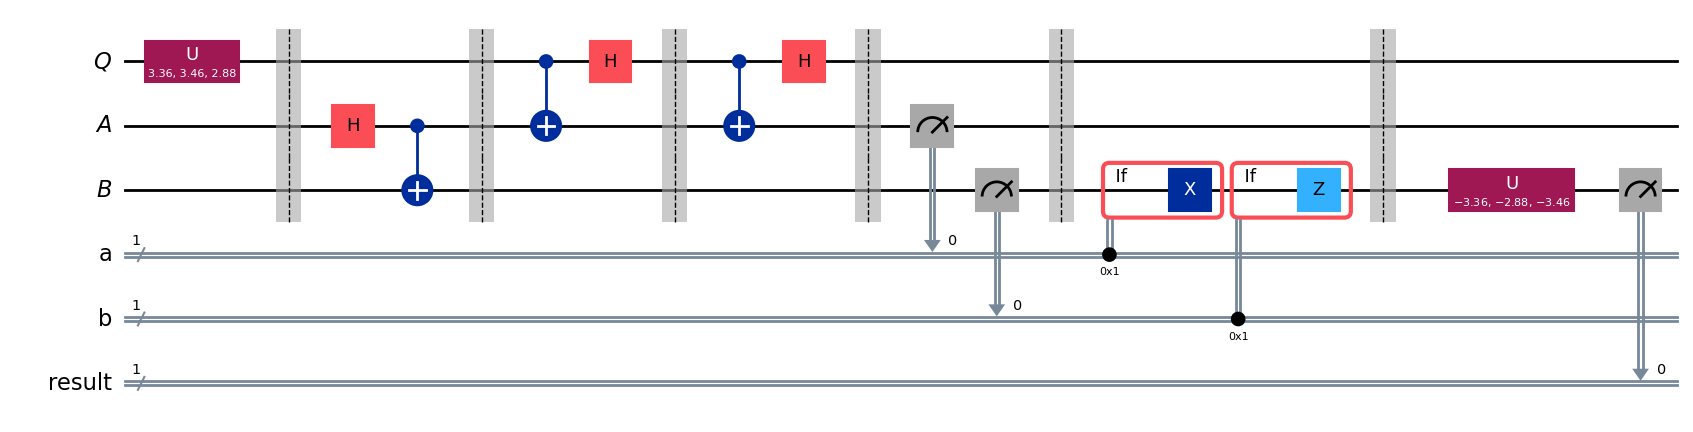

In [17]:
result = ClassicalRegister(1, 'result')
test.add_register(result)
test.measure(ebit1, result)

display(test.draw('mpl'))

Finally let's run the Aer simulator on this circuit and plot a histogram of the outputs.
We'll see the statistics for all three classical bits: the bottom/leftmost bit should always
be 0,indicating that the qubit Q was successfully teleported into B, while the other two
bits should be roughly uniform.

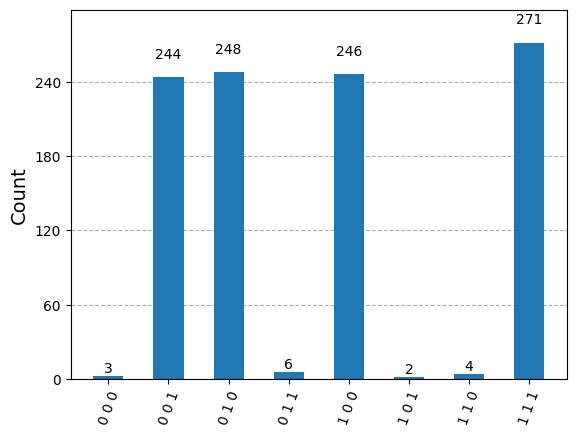

In [18]:
result = AerSimulator().run(test).result()
statists = result.get_counts()
display(plot_histogram(statists))

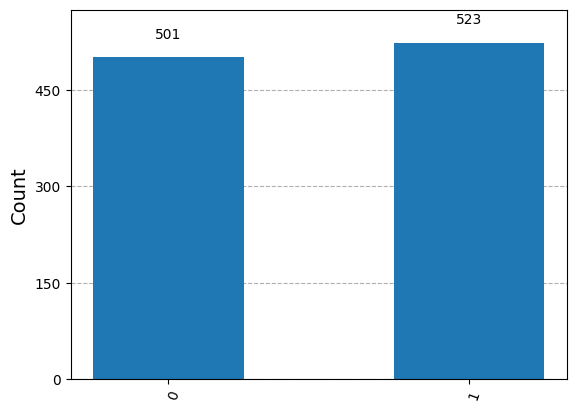

In [19]:
filtered_stats = marginal_distribution(statists, [2])
display(plot_histogram(filtered_stats))